In [29]:
import os
import importlib
import numpy as np
import pandas as pd
import librosa as lr
import features as fts
import ensemble as ens
import utils
importlib.reload(utils)
from utils import colored
import split
from time import time
from json import dumps
import models
import matplotlib.pyplot as plt
importlib.reload(fts)
importlib.reload(split)
importlib.reload(ens)
_ = importlib.reload(models)
import seaborn as sns
sns.set(palette='GnBu_d')
from sklearn.metrics import classification_report
from jupyterthemes import jtplot
jtplot.style(theme='onedork')

In [30]:
plt.rcParams['figure.figsize'] = [14, 4]

In [31]:
frame = np.load('../data/audio/actors.frame.npy', allow_pickle=True)

In [32]:
test_frame = frame[1080:]
train_frame = frame[:1080]

In [33]:
start = time()
features = np.array([
    fts.extract_from(sample['signal'], sample['sample_rate']) for sample in frame
])
end = time()
print(f'Processed {features.shape[0]} samples in {round(end - start, 5)} seconds')

Processed 1440 samples in 55.13239 seconds


In [6]:
features.shape

(1440, 17)

In [7]:
# np.save('../data/audio/actors.features', features, allow_pickle=True)

In [8]:
# features = np.load('../data/audio/actors.features.npy')

In [9]:
test_features = features[1080:]
train_features = features[:1080]

In [10]:
# check samples duration
total = 0
for s in train_frame['signal']:
    l  = s.shape[0]
    total += l
mins = ((total / 22050) / 60)
print(f'Loaded {round(mins, 2)} minutes of audio.')

Loaded 66.7 minutes of audio.


In [69]:
import lightgbm
from sklearn.model_selection import train_test_split


for EM in emotions:

    y = (train_frame['emotion'] == EM).astype(np.int)

    x, x_test, y, y_test = train_test_split(train_features, y, test_size=0.2, random_state=42, stratify=y)

    train_data = lightgbm.Dataset(x, label=y)
    test_data = lightgbm.Dataset(x_test, label=y_test)

    parameters = {
        'application': 'binary',
        'objective': 'binary',
        'metric': 'auc',
        'is_unbalance': 'false',
        'boosting': 'gbdt',
        'num_leaves': 70,
        'feature_fraction': 0.5,
        'bagging_fraction': 0.5,
        'bagging_freq': 20,
        'learning_rate': 0.02,
        'max_bin': 10000,
        'verbose': 0
    }

    model = lightgbm.train(parameters,
                           train_data,
                           verbose_eval=False,
                           valid_sets=test_data,
                           num_boost_round=5000,
                           early_stopping_rounds=500)

    preds = model.predict(test_features, num_iteration=model.best_iteration)

    px = (preds > 0.5).astype(np.int)
    rep = classification_report(px, (test_frame['emotion'] == EM).astype(np.int))


    # em = pd.DataFrame(columns=emotions)

    # for p, e in zip(preds, test_frame['emotion']):    
    #     print(f'{e:>12} - {round(p * 100, 3):>6}')
    print(EM)
    print(rep)

angry
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       335
           1       0.44      0.76      0.56        25

    accuracy                           0.92       360
   macro avg       0.71      0.84      0.76       360
weighted avg       0.94      0.92      0.93       360

calm
              precision    recall  f1-score   support

           0       0.97      0.92      0.95       335
           1       0.38      0.64      0.48        25

    accuracy                           0.90       360
   macro avg       0.68      0.78      0.71       360
weighted avg       0.93      0.90      0.91       360

disgust
              precision    recall  f1-score   support

           0       0.99      0.85      0.91       355
           1       0.02      0.20      0.03         5

    accuracy                           0.84       360
   macro avg       0.50      0.52      0.47       360
weighted avg       0.97      0.84      0.90       360



In [12]:
# train one classifier per emotion
clfs = {}
emotions = np.unique(frame['emotion']).tolist()
for emotion in emotions:
    # train class vector
    y_train = (train_frame['emotion'] == emotion).astype(np.int)
    
    # fit model
    pipe, score = models.svm(train_features, y_train, probability=True)
    
    # add to pipe
    clfs[emotion] = pipe
    
    # build target class array
    y_test = (test_frame['emotion'] == emotion).astype(np.int)
    
    # predict classes
    y_test_pred = pipe.predict(test_features)
    
    # get report
    report = classification_report(y_test, y_test_pred)
#     report.
    C = pipe.steps[1][1].C
    train_score = round(score, 2)
    print(f'{emotion:>12} - C = {C} - Train score = {train_score}')
    print(report)

       angry - C = 7 - Train score = 0.94
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       317
           1       0.85      0.51      0.64        43

    accuracy                           0.93       360
   macro avg       0.89      0.75      0.80       360
weighted avg       0.93      0.93      0.92       360

        calm - C = 16 - Train score = 0.9
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       318
           1       0.63      0.62      0.63        42

    accuracy                           0.91       360
   macro avg       0.79      0.79      0.79       360
weighted avg       0.91      0.91      0.91       360

     disgust - C = 16 - Train score = 0.9
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       305
           1       0.64      0.29      0.40        55

    accuracy                           0.87       360
  

/home/juraj/Code/milacc/env/lib64/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


     neutral - C = 1 - Train score = 0.93
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       339
           1       0.00      0.00      0.00        21

    accuracy                           0.94       360
   macro avg       0.47      0.50      0.48       360
weighted avg       0.89      0.94      0.91       360

         sad - C = 4 - Train score = 0.89
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       311
           1       0.85      0.22      0.35        49

    accuracy                           0.89       360
   macro avg       0.87      0.61      0.65       360
weighted avg       0.88      0.89      0.86       360

   surprised - C = 6 - Train score = 0.89
              precision    recall  f1-score   support

           0       0.91      0.98      0.95       316
           1       0.70      0.32      0.44        44

    accuracy                           0.90       360
  

In [13]:
models.save('ensemble', clfs)

In [14]:
clfs = models.load('ensemble')

In [26]:
N = 10

# choose N random samples
choices = np.random.choice(test_frame.shape[0], N)


for idx in choices:
    # pick a sample
    f = test_frame[idx]
    em = f['emotion']
    
    print(f'\n({em[:4]:^6})', end='')
    
    # get probabilities of individual classifiers
    guesses = ens.probs(clfs, f['signal'], f['sample_rate'])
    
    # print top 4 guesses
    for e, g in guesses:
        print(f'  {colored(round(g * 100, 1))} {e[:3]:<3}', end='')


( disg )    23.7% cal    13.4% dis    10.4% hap     7.3% sad     3.6% fea     3.2% neu     3.1% sur     2.1% ang
( calm )    23.7% cal    13.4% dis    10.4% hap     7.3% sad     3.6% fea     3.2% neu     3.1% sur     2.1% ang
( angr )    23.7% cal    13.4% dis    10.4% hap     7.3% sad     3.6% fea     3.2% neu     3.1% sur     2.1% ang
( disg )    23.7% cal    13.4% dis    10.4% hap     7.3% sad     3.6% fea     3.2% neu     3.1% sur     2.1% ang
( surp )    23.7% cal    13.4% dis    10.4% hap     7.3% sad     3.6% fea     3.2% neu     3.1% sur     2.1% ang
( angr )    23.7% cal    13.4% dis    10.4% hap     7.3% sad     3.6% fea     3.2% neu     3.1% sur     2.1% ang
( sad  )    23.7% cal    13.4% dis    10.4% hap     7.3% sad     3.6% fea     3.2% neu     3.1% sur     2.1% ang
( sad  )    23.7% cal    13.4% dis    10.4% hap     7.3% sad     3.6% fea     3.2% neu     3.1% sur     2.1% ang
( calm )    23.7% cal    13.4% dis    10.4% hap     7.3% sad     3.6% fea     3.2% neu     3.1%

---
## Segmentation

In [71]:
import settings
# load long sample - ~5 minutes
y, sr = lr.core.load(f'{settings.DATA_PATH}/audio/cold-sales-call.wav')

In [72]:
def log_norm_energy(y):
    e = fts.energy(y)
    return np.log1p(e).mean()

In [73]:
segs, intervals = split.on_silence(y)

emos = pd.DataFrame(columns=emotions)

for ctx, seg in enumerate(segs):
    if log_norm_energy(seg) < 0.01:
        continue
    guesses = ens.probs(clfs, seg)
    for e, g in guesses:
        emos.loc[ctx, e] = g

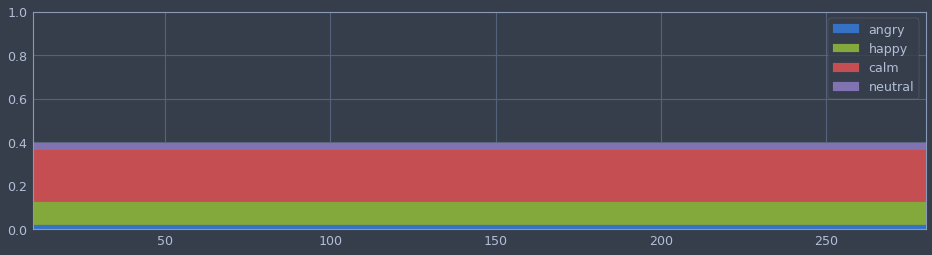

In [74]:
_ = emos[['angry', 'happy', 'calm', 'neutral']].plot.area(stacked=True, figsize=(16, 4), ylim=(0, 1))

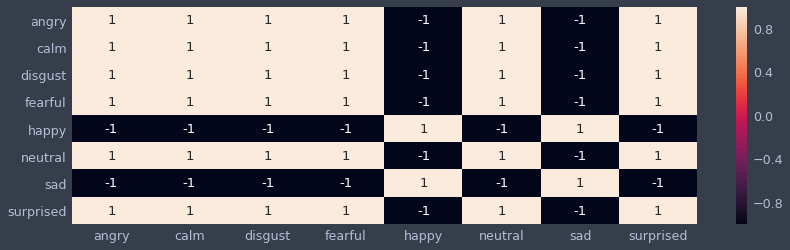

In [75]:
_ = sns.heatmap(emos.astype(np.float).corr(), annot=True, cbar=True)